In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env

In [3]:
from IPython.display import HTML
HTML("<style>div.output_area pre { font-family: 'Courier New', monospace; }</style>")

In [4]:
from apad_env import APADEnv, has_islands

Coordinate system: Top left is 0,0. Zeroeth row, second column would be 0,2.

In [5]:
env = APADEnv()
check_env(env)

# basic sanity checks of the environment

In [6]:
def test_environment():
    env = APADEnv()
    
    # Test 1: Grid initialization
    assert env.grid.shape == (7, 7)
    assert np.sum(env.grid == -1) == 6  # Invalid positions
    assert np.sum(env.remaining_pieces) == 8  # All pieces available
    
    # Test 2: Piece coordinate generation
    coords_k = env._get_piece_coords(0, 0, 0)  # K piece, no flip, no rotation
    expected_k = [(0,0), (1,0), (2,0), (3,0), (2,1)]
    assert coords_k == expected_k
    
    # Test 3: Rotation
    coords_k_rot = env._get_piece_coords(0, 0, 1)  # K piece rotated 90°
    assert len(coords_k_rot) == 5
    
    # Test 4: Valid placement
    valid = env._is_valid_placement(0, 0, 0, 14)  # Position (2,0) on grid
    assert isinstance(valid, np.bool_)
    
    # Test 5: Invalid placement (out of bounds)
    valid = env._is_valid_placement(0, 0, 0, 6)  # Top-right corner invalid
    assert valid == False
    
    # Test 6: Piece placement
    if env._is_valid_placement(0, 0, 0, 14):
       env._place_piece_components(0, 0, 0, 14)
       assert not env.remaining_pieces[0]  # Piece marked as used
       assert np.sum(env.grid == 1) == 5   # 5 cells occupied by piece
    
    print("All tests passed")
    
test_environment()

All tests passed


### Make sure we can't place pieces on top of each other. Make sure we can reset the environment.

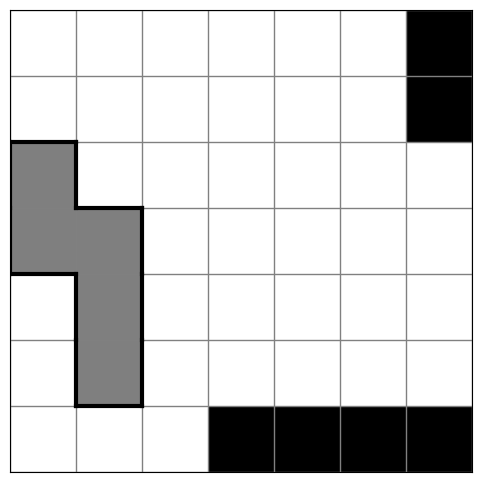

Overlap and reset tests passed!


In [7]:
def test_overlap_and_reset():
    env = APADEnv()
    
    # Find two valid positions for same piece type
    pos1 = 14  # Should be valid
    pos2 = 15  # Adjacent position
    
    # Place first piece
    if env._is_valid_placement(0, 0, 0, pos1):
        env._place_piece_components(1, 0, 0, pos1)
        env.visualize()
       
        # Try to place overlapping piece (should fail)
        overlap_valid = env._is_valid_placement(0, 0, 0, pos2)
        assert overlap_valid == False
        
        # Test reset
        obs, info = env.reset()
        assert np.sum(env.remaining_pieces) == 8  # All pieces available
        assert np.sum(env.grid > 0) == 0  # Only invalid cells marked
       
    print("Overlap and reset tests passed!")
    return env

test_overlap_and_reset()

### Validate island-finding

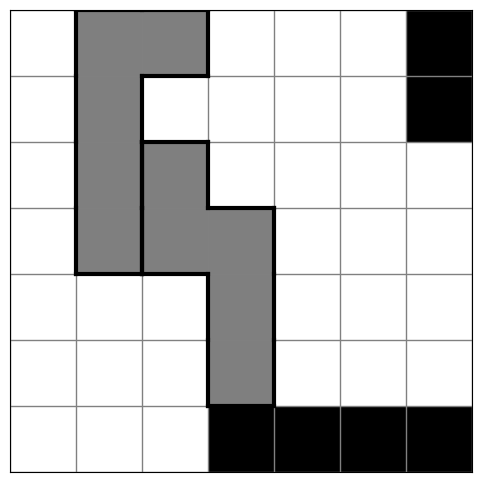

here's the grid as the island finder sees it
[[1 0 0 2 2 2 0]
 [1 0 2 2 2 2 0]
 [1 0 0 2 2 2 2]
 [1 0 0 0 2 2 2]
 [1 1 1 0 2 2 2]
 [1 1 1 0 2 2 2]
 [1 1 1 0 0 0 0]]
there are 2 separate islands of unoccupied cells

the numbers of cells in each group (including the total number of occupied/invalid cells at the zeroeth index)
[16 13 20]

Are there groups of unoccupied cells of size <= 4?
False

island-finding test passed!


In [8]:
from scipy.ndimage import label

def validate_island_finding(grid):
    # pass label() a grid of T/F, T where the cells are 0 (empty), F where they are !=0 (invalid/occupied).
    labeled_array, num_features = label(env.grid == 0)
    
    # 1's where there are empty cells, 0's where they are occupied/invalid
    print("here's the grid as the island finder sees it")
    print(labeled_array)
    
    # number of separate groups.
    print(f'there are {num_features} separate islands of unoccupied cells')
    
    # flatten the grid to 1D
    #print(labeled_array.ravel())
    
    # [number of 0s, number of not-zeroes in group1, number of not-zeroes in group2, ...]
    print("\nthe numbers of cells in each group (including the total number of occupied/invalid cells at the zeroeth index)")
    print(np.bincount(labeled_array.ravel()))
    
    island_sizes = np.bincount(labeled_array.ravel())[1:]
    
    # Check if any islands have 4 or fewer cells
    print("\nAre there groups of unoccupied cells of size <= 4?")
    print(np.any(island_sizes <= 4))

    assert not has_islands(grid)

    print("\nisland-finding test passed!")

env = APADEnv()
env._place_piece_components(1, 0, 0, 16)
env._place_piece_components(6, 0, 0, 1)
#env._place_piece_components(2, 0, 0, 4)
env.visualize()
validate_island_finding(env.grid)


# piece placement visualization and sanity-checks
Make sure pieces are being placed correctly. And understand the action->position/piece/rotation/chirality encoding.
e.g. 
- action 2408 = Z piece placed in the top-left
- action 2451 = Z piece placed int he top-left, but rotated
- 2451 - 2408 = 43 possible cells where each piece can be placed
- in practice, not all of these cells are valid, even if the board is empty

Chosen action: {'piece_id': 7, 'chirality': 0, 'rotation': 0, 'position': 0, 'grid_pos': (0, 0), 'piece_name': 'Z'}


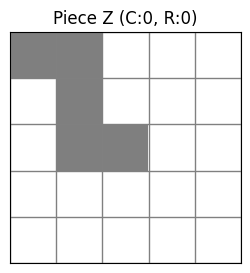

In [9]:
env = APADEnv()
action = 2408
print(f"Chosen action: {env.decode_action_verbose(action)}")
env.visualize_piece(action)

Chosen action: {'piece_id': 7, 'chirality': 0, 'rotation': 1, 'position': 0, 'grid_pos': (0, 0), 'piece_name': 'Z'}


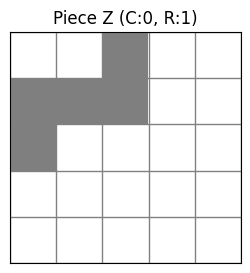

In [10]:
action = 2451
print(f"Chosen action: {env.decode_action_verbose(action)}")
env.visualize_piece(action)

At action 2580 (=2451+3*43, for the 3 remaining rotation configurations in each possible cell), we get our first chirality flip for the z-piece

Chosen action: {'piece_id': 7, 'chirality': 1, 'rotation': 0, 'position': 0, 'grid_pos': (0, 0), 'piece_name': 'Z'}


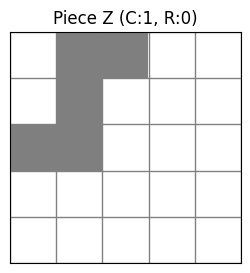

In [11]:
action = 2580
print(f"Chosen action: {env.decode_action_verbose(action)}")
env.visualize_piece(action)

# Run through a single random game

In [76]:
# N.B. without action masking, we can brick the game: no islands but no valid moves
# step() assumes action masking and doesn't waste time checking whether there are any valid moves at all
def test_random_trial():
    env = APADEnv()
    obs, _ = env.reset()
    done = False
    truncated = False
    
    while not done and not truncated:
        action = env.action_space.sample()  # Random action
        obs, reward, done, truncated, info = env.step(action)

    return env, done, truncated

### Validate island-finding

False True
True


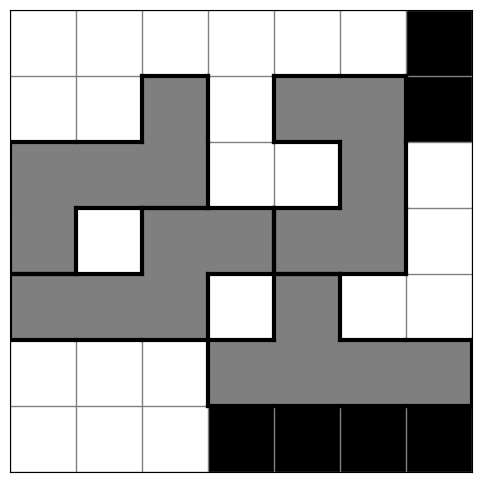

In [74]:
env, done, truncated = test_random_trial()
print(done, truncated)
print(has_islands(env.grid))
env.visualize()

### validate action-masking
Now, do use the action mask

In [79]:
def test_random_game(env, verbose=False):
    obs, info = env.reset()
    done = False
    steps = 0
    total_reward = 0
    
    while not done:
        valid_actions = np.where(info["action_mask"])[0]
        if len(valid_actions) == 0:
            break
        action = np.random.choice(valid_actions)

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        steps += 1
        total_reward += reward
        
        if verbose:
            print(f"Step {steps}: {env.decode_action_verbose(action)}, reward={reward}")
    
    return steps, total_reward

In [80]:
env = APADEnv()
assert env.action_masks().shape == (env.action_space.n,)

### play random trials until we get a success
this takes a couple minutes!

trial 187 15.0 seconds elapsed... 12.46 games/second
trial 368 30.0 seconds elapsed... 12.25 games/second
trial 555 45.0 seconds elapsed... 12.32 games/second
trial 741 60.1 seconds elapsed... 12.34 games/second
trial 929 75.1 seconds elapsed... 12.37 games/second
trial 1117 90.1 seconds elapsed... 12.40 games/second
trial 1303 105.1 seconds elapsed... 12.39 games/second
trial 1491 120.2 seconds elapsed... 12.40 games/second
trial 1679 135.2 seconds elapsed... 12.42 games/second
trial 1866 150.3 seconds elapsed... 12.42 games/second
trial 2053 165.3 seconds elapsed... 12.42 games/second
trial 2242 180.3 seconds elapsed... 12.43 games/second
trial 2430 195.3 seconds elapsed... 12.44 games/second
trial 2614 210.4 seconds elapsed... 12.43 games/second
trial 2798 225.5 seconds elapsed... 12.41 games/second
trial 2982 240.5 seconds elapsed... 12.40 games/second


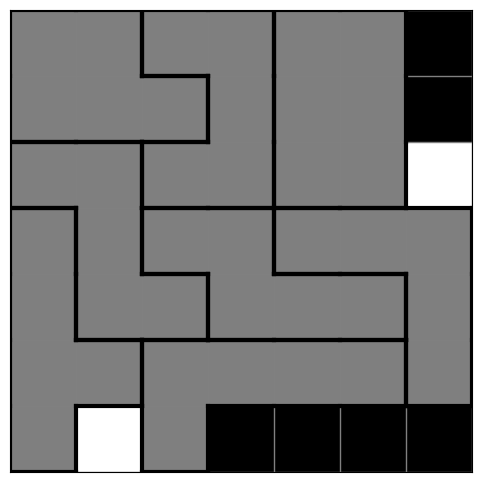

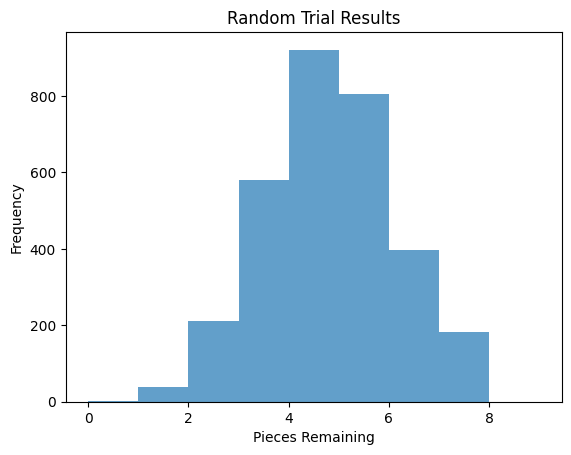

Trials: 3133, Success rate: 0.03%


In [81]:
import time

start_time = time.time()
last_print = start_time

i = 0
remaining_pieces = []
try:
    while True:
        i += 1
        env = APADEnv()
        steps, reward = test_random_game(env)
        remain = 8 - steps
        remaining_pieces.append(remain)
        if remain == 0: # win
            env.visualize()
            break
        current_time = time.time()
        if current_time - last_print >= 15:
            elapsed = current_time - start_time
            print(f"trial {i} {elapsed:.1f} seconds elapsed... {i/elapsed:.2f} games/second")
            last_print = current_time

except KeyboardInterrupt:
    env.visualize()

plt.hist(remaining_pieces, bins=range(10), alpha=0.7)
plt.xlabel('Pieces Remaining')
plt.ylabel('Frequency')
plt.title('Random Trial Results')
plt.savefig('trial_results.png')
plt.show()

print(f"Trials: {i}, Success rate: {remaining_pieces.count(0)/i:.2%}")

~~most of the time we end up with 2 remaining pieces when we place them all randomly~~

bricking the game in the step function when islands of 2-4 empty cells remain reduces the number of trials required by 10-20x.

In [ ]:
has_islands(env.grid)

In [82]:
def test_random_game_2():
    env = APADEnv()
    obs, _ = env.reset()
    
    while True:
        # Check if any valid moves exist
        valid_moves = []
        for action in range(env.action_space.n):
            piece_id = action // (2 * 4 * 43)
            if env.remaining_pieces[piece_id]:
                remaining = action % (2 * 4 * 43)
                chirality = remaining // (4 * 43)
                remaining = remaining % (4 * 43)
                rotation = remaining // 43
                position = remaining % 43
                if env._is_valid_placement(piece_id, chirality, rotation, position):
                    valid_moves.append(action)
       
        if not valid_moves:
            break
           
        action = np.random.choice(valid_moves)
        obs, reward, done, truncated, _ = env.step(action)
        
        if done or truncated:
            break
    
    #print(f"Pieces remaining: {sum(env.remaining_pieces)}")
    return env

trial 93 15.0 seconds elapsed... 6.18 games/second
trial 187 30.1 seconds elapsed... 6.21 games/second
trial 277 45.1 seconds elapsed... 6.14 games/second
trial 371 60.2 seconds elapsed... 6.16 games/second
trial 461 75.3 seconds elapsed... 6.12 games/second
trial 553 90.4 seconds elapsed... 6.12 games/second
trial 645 105.5 seconds elapsed... 6.12 games/second
trial 735 120.5 seconds elapsed... 6.10 games/second
trial 826 135.7 seconds elapsed... 6.09 games/second
trial 917 150.8 seconds elapsed... 6.08 games/second
trial 1008 165.9 seconds elapsed... 6.08 games/second
trial 1097 180.9 seconds elapsed... 6.06 games/second
trial 1188 195.9 seconds elapsed... 6.06 games/second
trial 1280 211.0 seconds elapsed... 6.07 games/second
trial 1371 226.1 seconds elapsed... 6.06 games/second
trial 1463 241.2 seconds elapsed... 6.07 games/second
trial 1555 256.2 seconds elapsed... 6.07 games/second


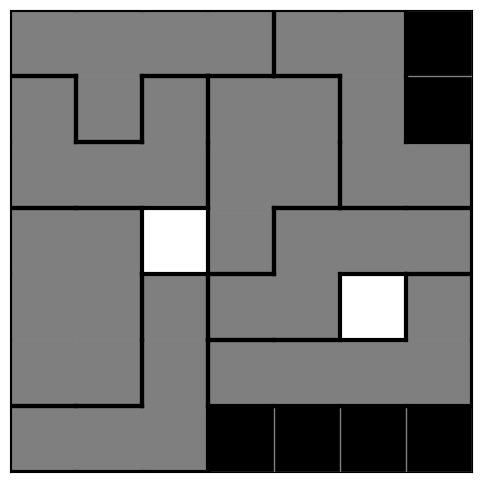

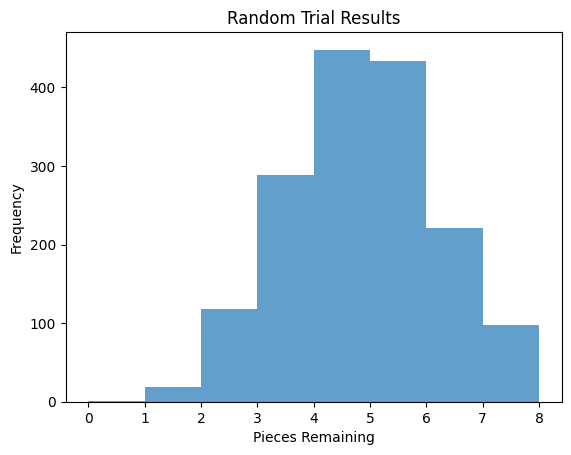

Trials: 1628, Success rate: 0.06%


In [84]:
import time

start_time = time.time()
last_print = start_time

i = 0
remaining_pieces = []
try:
    while True:
        i += 1
        env = test_random_game_2()
        remaining_pieces.append(np.sum(env.remaining_pieces))
        if np.sum(env.remaining_pieces) == 0:
            env.visualize()
            break
        current_time = time.time()
        if current_time - last_print >= 15:
            elapsed = current_time - start_time
            print(f"trial {i} {elapsed:.1f} seconds elapsed... {i/elapsed:.2f} games/second")
            last_print = current_time

except KeyboardInterrupt:
    env.visualize()

plt.hist(remaining_pieces, bins=range(9), alpha=0.7)
plt.xlabel('Pieces Remaining')
plt.ylabel('Frequency')
plt.title('Random Trial Results')
plt.savefig('trial_results.png')
plt.show()

print(f"Trials: {i}, Success rate: {remaining_pieces.count(0)/i:.2%}")